Importing the important libraries

In [ ]:
from __future__ import print_function
import keras
import json
import copy
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


In [ ]:
save_dir    = os.path.join(os.getcwd(), 'drive/My Drive/NEU/7150/HW2/Models/')
model_name  = 'keras_cifar10_trained_model_bn_B64_e30.h5'
num_classes = 10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Loading the CIFAR10 data

In [ ]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# scaling the pixel values to (0,1)
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train_1 = keras.utils.to_categorical(y_train, num_classes)
y_test_1 = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 6s 0us/step


Loading the already trained model on CIFAR10

In [ ]:
model = load_model(save_dir + model_name)

Preparing the test images

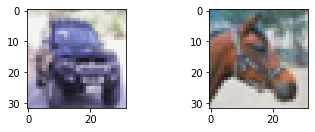

Image1 class: automobile
Image2 class: horse


In [ ]:
img1        = copy.deepcopy(x_test[9:10])
img2        = copy.deepcopy(x_test[17:18])
label1      = copy.deepcopy(y_test_1[9])
label2      = copy.deepcopy(y_test_1[17])

targetClass = 5 # dog
target      = keras.utils.to_categorical(targetClass, num_classes)
epsilon     = 0.01

plt.subplot(220+1)
plt.imshow(img1[0])
plt.subplot(220+2)
plt.imshow(img2[0])
plt.show()

print('Image1 class:', class_names[np.argmax(label1)])
print('Image2 class:', class_names[np.argmax(label2)])

Utility methods:

1. function *getAdversarialData*

  Inputs: (*Trained model, Original image, Epsilon, Original Class, Target Class, Maximum number of epochs, Different class names*)
  
  Outputs a tuple: (Adversarial image, Perturbations)

2. function *displayImages*

  Inputs: (*Original image, Adversarial image, Perturbations*)


In [ ]:
def getAdversarialData(model, img, epsilon, originalClass, targetClass, maxEpochs, class_names):
  print('Inputs: Epsilon:',epsilon,'Original class:',originalClass,'Target class:',targetClass,'maxEpochs:',maxEpochs)

  predictions = model.predict_proba(img)
  target      = keras.utils.to_categorical(targetClass, 10) # 10 is the total number of classes in CIFAR10
  prevLoss    = keras.losses.categorical_crossentropy(target, predictions[0])
  advImg      = copy.deepcopy(img)  

  print('Initial prediction:', predictions)
  print('Initial predicted class:', class_names[np.argmax(predictions[0])])
  print('Intial loss:', prevLoss)

  for epoch in range(maxEpochs):
    print('Epoch:', epoch)

    for row in range(32):
      for col in range(32):
        for pixel in range(3):
          
          oldPixelValue = advImg[0][row][col][pixel]

          # add epsilon to current pixel and check the new loss
          advImg[0][row][col][pixel] = oldPixelValue + epsilon

          predictions = model.predict(advImg)
          currLoss    = keras.losses.categorical_crossentropy(target, predictions[0])

          # our aim is to minimize the loss until we get the target class in the prediction
          if currLoss > prevLoss:
            advImg[0][row][col][pixel] = oldPixelValue - epsilon

            predictions = model.predict(advImg)
            currLoss    = keras.losses.categorical_crossentropy(target, predictions[0])

            # if the loss did not decrease, bring the pixel back to original value
            if currLoss > prevLoss:
              advImg[0][row][col][pixel] = oldPixelValue

              predictions = model.predict(advImg)
              currLoss    = keras.losses.categorical_crossentropy(target, predictions[0])
          
          prevLoss = currLoss

    print('Current prediction: Actual class - ', predictions[0][originalClass], ' Target class - ', predictions[0][targetClass])
    print('Current predicted class:', class_names[np.argmax(predictions[0])])
    
    if np.argmax(predictions, 1)[0] == targetClass:
      break  
  
  # return (Original Image, Adversarial Image, Perturbations)
  return (advImg, advImg - img)

def displayImages(orgImg, advImg, perturbation):
  plt.subplot(330 + 1)
  plt.imshow(orgImg[0])
  plt.subplot(330 + 2)
  plt.imshow(advImg[0])
  plt.subplot(330 + 3)
  plt.imshow(perturbation[0] * 255)
  plt.show()

Result 1 : An automobile is classified as a dog

Inputs: Epsilon: 0.02 Original class: 1 Target class: 5 maxEpochs: 100
Initial prediction: [[1.2510685e-05 7.3899025e-01 2.5120991e-05 9.6214926e-06 2.6997002e-06
  4.2650332e-05 2.9265296e-04 3.5163109e-06 6.2421554e-05 2.6055852e-01]]
Initial predicted class: automobile
Intial loss: tf.Tensor(10.062475, shape=(), dtype=float32)
Epoch: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current prediction: Actual class -  0.0001527317  Target class -  0.99842995
Current predicted class: dog


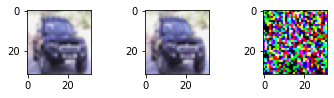

Original class: automobile
Adversarial image class: dog
Adversarial image prediction: [2.0772422e-06 1.5273171e-04 3.1858718e-04 7.1850483e-04 3.3401409e-06
 9.9842995e-01 1.3561033e-04 1.8003043e-04 2.5635991e-06 5.6548153e-05]


In [ ]:
originalClass1          = np.argmax(label1)
advImg1, perturbation1  = getAdversarialData(model, img1, 0.02, originalClass1, targetClass, 100, class_names)

displayImages(img1, advImg1, perturbation1)
predictions1 = model.predict_proba(advImg1)
print('Original class:', class_names[originalClass1])
print('Adversarial image class:', class_names[np.argmax(predictions1[0])])
print('Adversarial image prediction:', predictions1[0])

Result 2: A horse is classified as a dog

Inputs: Epsilon: 0.02 Original class: 7 Target class: 5 maxEpochs: 100
Initial prediction: [[4.4390213e-04 8.8969647e-04 2.2271671e-04 1.3562932e-03 2.2093231e-04
  1.3849735e-02 6.9754366e-03 9.7497720e-01 8.7741073e-06 1.0553640e-03]]
Initial predicted class: horse
Intial loss: tf.Tensor(4.2794895, shape=(), dtype=float32)
Epoch: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Current prediction: Actual class -  1.3419829e-05  Target class -  0.9999261
Current predicted class: dog


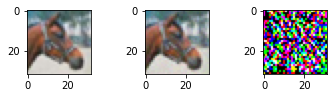

Original class: horse
Adversarial image class: dog
Adversarial image prediction: [2.3852104e-07 1.3190019e-07 5.5428455e-07 4.9042683e-05 4.7101651e-08
 9.9992609e-01 9.4246570e-06 1.3419829e-05 2.8499187e-09 1.0190702e-06]


In [ ]:
originalClass2          = np.argmax(label2)
advImg2, perturbation2 = getAdversarialData(model, img2, 0.02, originalClass2, targetClass, 100, class_names)
displayImages(img2, advImg2, perturbation2)
predictions2 = model.predict_proba(advImg2)
print('Original class:', class_names[originalClass2])
print('Adversarial image class:', class_names[np.argmax(predictions2[0])])
print('Adversarial image prediction:', predictions2[0])